In [1]:
from typing import List, Tuple
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
from sklearn.cluster import KMeans


def standardize_data(df: pd.DataFrame) -> pd.DataFrame:
    scaler = StandardScaler()
    standardized_data = scaler.fit_transform(df)
    return standardized_data


def perform_pca(data: pd.DataFrame, components: int) -> np.ndarray:
    pca = PCA(n_components=components)
    principal_components = pca.fit_transform(data)
    return principal_components


def plot_scatter(data: pd.DataFrame, labels=None) -> None:
    plt.figure(figsize=(8, 6))
    plt.scatter(data[:, 0], data[:, 1], c=labels, edgecolor="k", alpha=0.7)
    plt.title("PCA Scatter Plot")
    plt.xlabel("Principal Component 1")
    plt.ylabel("Principal Component 2")
    plt.show()


def perform_kmeans(data: pd.DataFrame, k_values: List[int]) -> Tuple[List[int]]:
    results = []
    # distortions = avg of the squared distances from each point to its assigned cluster centroid
    distortions = []
    for i in k_values:
        kmeans = KMeans(n_clusters=i, n_init=10, random_state=0)
        kmeans.fit(data)
        results.append(kmeans)
        # inertia is "compactness" or "spread" of samples across clusters. Lower inertia = clusters are more tightly grouped
        distortions.append(kmeans.inertia_)
    return distortions, results


def plot_elbow_chart(k_values: int, distortions: List[int]):
    plt.figure(figsize=(8, 6))
    plt.plot(k_values, distortions, marker="o")
    plt.title("Elbow Chart")
    plt.xlabel("Number of clusters (K)")
    plt.ylabel("Distortion")
    plt.show()

(1896, 36)


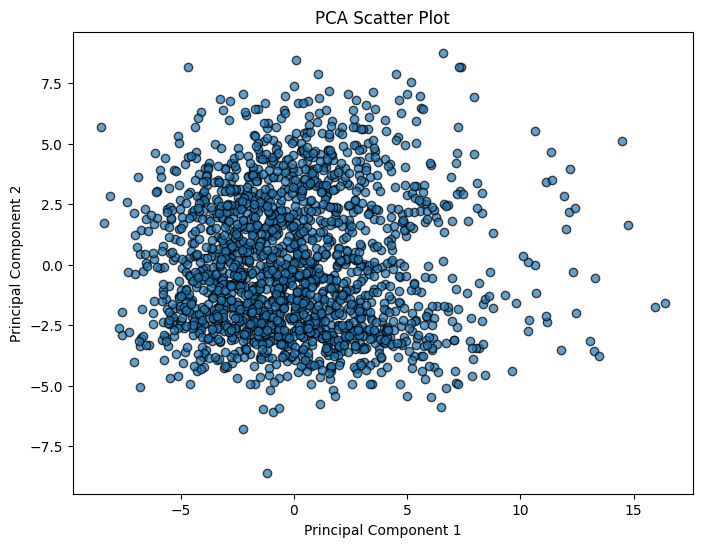

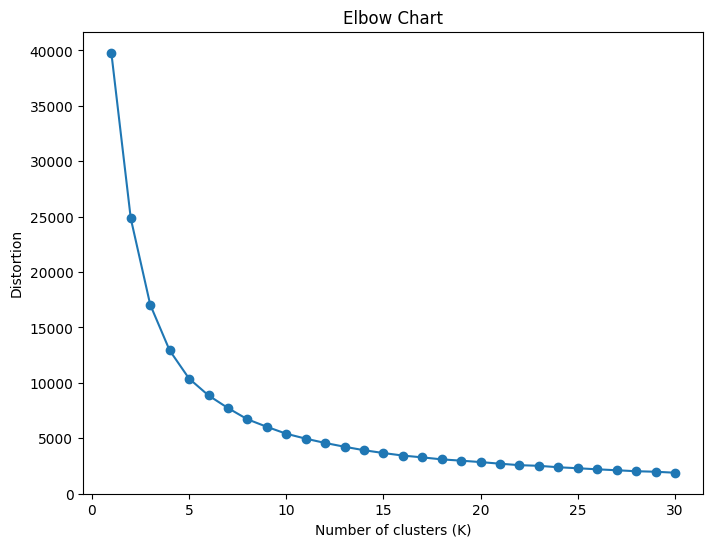

In [2]:
# drop Nan rows (only 1 row)
df_raw = pd.read_csv("cleaned_data/nba_cleaned_data.csv").dropna()
df_raw = df_raw.set_index("player_id")

# select only the features to be used in clustering
features = [
    "games_played",
    "seasons_played",
    "avg_ts_percent",
    "avg_per",
    "avg_mpg",
    "avg_x3p_ar",
    "avg_orb_percent",
    "avg_drb_percent",
    "avg_ast_percent",
    "avg_stl_percent",
    "avg_blk_percent",
    "avg_tov_percent",
    "avg_usg_percent",
    "avg_ows_48",
    "avg_dws_48",
    "avg_obpm",
    "avg_dbpm",
    "avg_bpm",
    "avg_vorp",
    "max_ts_percent",
    "max_per",
    "max_mpg",
    "max_x3p_ar",
    "max_orb_percent",
    "max_drb_percent",
    "max_ast_percent",
    "max_stl_percent",
    "max_blk_percent",
    "max_tov_percent",
    "max_usg_percent",
    "max_ows_48",
    "max_dws_48",
    "max_obpm",
    "max_dbpm",
    "max_bpm",
    "max_vorp",
]
df = df_raw[features]
# df = df_raw.iloc[:, 1:]
print(df.shape)

# Standardize the data
df_std = standardize_data(df)

# grab top 2 PCA
principal_components = perform_pca(df_std, components=2)

# Plot Scatter of 2D PCA
plot_scatter(principal_components)

# Perform K-means clustering with different values of K
k_values = list(range(1, 31))
distortions, results = perform_kmeans(principal_components, k_values)

# Plot the elbow chart
plot_elbow_chart(k_values, distortions)

In [3]:
# select desired K-value based on elbow chart
selected_k_value = 7
model_idx = k_values.index(selected_k_value)
selected_clustering = results[model_idx]
assert selected_clustering.n_clusters == selected_k_value, "K value mismatch"

# add cluster back to raw data frame
df_raw["cluster_label"] = selected_clustering.labels_

In [4]:
df_awards = pd.read_csv("cleaned_data/nba_cleaned_data_v2.csv")
awards_cols = [
    "player_id",
    "ALL_NBA_total",
    "ALL_DEF_total",
    "1T_ALL_NBA_total",
    "2T_ALL_NBA_total",
    "3T_ALL_NBA_total",
    "1T_ALL_DEF_total",
    "2T_ALL_DEF_total",
    "DPOY_total",
    "MIP_total",
    "MVP_total",
    "ROY_total",
    "SMOY_total",
]
df_awards = df_awards[awards_cols].set_index("player_id")
df_joined = df_raw.join(df_awards)

df_joined.to_csv("cleaned_data/clustered_data.csv", index=False)

In [5]:
# sanity check on join to awards data
df_lebron = df_joined[df_joined["player"] == "LeBron James"][["player", "cluster_label", *awards_cols[1:]]]
display(df_lebron)

lebron_cluster = df_lebron['cluster_label'].iloc[0]

,player,cluster_label,ALL_NBA_total,ALL_DEF_total,1T_ALL_NBA_total,2T_ALL_NBA_total,3T_ALL_NBA_total,1T_ALL_DEF_total,2T_ALL_DEF_total,DPOY_total,MIP_total,MVP_total,ROY_total,SMOY_total
player_id,,,,,,,,,,,,,,
3463,LeBron James,3,18.0,6.0,13.0,3.0,2.0,5.0,1.0,0.0,0.0,4.0,1.0,0.0


In [6]:
# sanity check on what appears to be the most elite cluster. Most (if not all) of these players are Hall-of-Fame caliber players
display(df_raw[df_raw["cluster_label"] == lebron_cluster][["player", "cluster_label"]])

,player,cluster_label
player_id,,
2110,Clyde Drexler,3
2162,Charles Barkley,3
1767,Marques Johnson,3
4032,Kawhi Leonard,3
3585,Chris Paul,3
4339,Karl-Anthony Towns,3
3830,Kevin Love,3
3092,Tim Duncan,3
2494,David Robinson,3


In [7]:
from pyspark.sql import SparkSession


spark = (
    SparkSession.builder.master("local[*]")
    .appName("local_testing")
    .config("spark.driver.host", "127.0.0.1")
    .getOrCreate()
    )

df_clustered = spark.read.csv("cleaned_data/clustered_data.csv", header=True)
df_clustered.createOrReplaceTempView('tmp_clustered')

Setting default log level to "WARN".
To adjust logging level use sc.setLogLevel(newLevel). For SparkR, use setLogLevel(newLevel).
23/12/03 17:04:11 WARN NativeCodeLoader: Unable to load native-hadoop library for your platform... using builtin-java classes where applicable
23/12/03 17:04:12 WARN Utils: Service 'SparkUI' could not bind on port 4040. Attempting port 4041.
23/12/03 17:04:20 WARN SparkStringUtils: Truncated the string representation of a plan since it was too large. This behavior can be adjusted by setting 'spark.sql.debug.maxToStringFields'.


In [8]:
df = spark.sql("""
    SELECT
        cluster_label,
        COUNT(*) AS cluster_size,
        AVG(games_played),
        AVG(seasons_played),
        AVG(pos_mapped),
        AVG(ALL_NBA_total),
        AVG(ALL_DEF_total),
        AVG(1T_ALL_NBA_total),
        AVG(2T_ALL_NBA_total),
        AVG(3T_ALL_NBA_total),
        AVG(1T_ALL_DEF_total),
        AVG(2T_ALL_DEF_total),
        AVG(DPOY_total),
        AVG(MIP_total),
        AVG(MVP_total),
        AVG(ROY_total),
        AVG(SMOY_total)
    FROM
        tmp_clustered
    GROUP BY 1
    ORDER BY 6
    """)

display(df.toPandas())

,cluster_label,cluster_size,avg(games_played),avg(seasons_played),avg(pos_mapped),avg(ALL_NBA_total),avg(ALL_DEF_total),avg(1T_ALL_NBA_total),avg(2T_ALL_NBA_total),avg(3T_ALL_NBA_total),avg(1T_ALL_DEF_total),avg(2T_ALL_DEF_total),avg(DPOY_total),avg(MIP_total),avg(MVP_total),avg(ROY_total),avg(SMOY_total)
0,5,298,238.040268,3.805369,4.060027,0.000000,0.006711,0.000000,0.000000,0.000000,0.000000,0.006711,0.000000,0.003356,0.000000,0.000000,0.000000
1,6,314,192.391720,3.098726,2.032713,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
2,1,490,456.071429,6.689796,2.234492,0.002041,0.063265,0.000000,0.000000,0.002041,0.026531,0.036735,0.002041,0.006122,0.000000,0.008163,0.008163
3,2,298,469.520134,6.953020,4.423802,0.003356,0.057047,0.000000,0.003356,0.000000,0.016779,0.040268,0.006711,0.016779,0.000000,0.003356,0.003356
4,4,279,734.602151,10.354839,1.981828,0.362007,0.354839,0.060932,0.146953,0.154122,0.139785,0.215054,0.010753,0.068100,0.003584,0.046595,0.093190
5,0,160,722.306250,10.231250,4.452400,0.656250,0.737500,0.093750,0.281250,0.281250,0.406250,0.331250,0.150000,0.025000,0.012500,0.056250,0.043750
6,3,57,971.596491,13.649123,2.709228,6.736842,2.877193,3.122807,2.192982,1.421053,1.684211,1.192982,0.192982,0.105263,0.701754,0.315789,0.035088
